# CS Miniproject 3 Code
# Team Name: enterOinked
# Team Members: Philip Carr, Bradley Justice, and Thomas Leing

## 21 Late Hours Were Used for This Code (and corresponding Piazza Post) (all late hours from Thomas Leing)

## Outline:
1. Overview
2. Introduction
3. Pre-processing (15 points): Parse the training data (Shakespeare sonnets text file).
4. Unsupervised Learning (10 points)
5. Poetry Generation, Part 1: Hidden Markov Models (20 points)
6. Poetry Generation, Part 2: Recurrent Neural Networks (20 points)
7. Additional Goals (20 points)
8. Visualization & Interpretation (15 points)

## 3. Pre-processing (15 points)

### Code for preprocessing training data

### Parse the training data (Shakespeare sonnets text file).

In [1]:
import os
import numpy as np
from IPython.display import HTML
import re
import random

from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission,
    obs_map_reverser
)

In [2]:
def get_sonnet_dict(filename="data/shakespeare.txt"):
    """
    Return a dictionary containing the sonnets in a
    given file.
    """
    sonnet_dict = {}
    shkspr_file = open(filename, "r")
    shkspr_lines = shkspr_file.readlines()
    shkspr_file.close()
    for i in range(len(shkspr_lines)):
        line = shkspr_lines[i]
        line = re.sub(",", ' ,', line).lower()
        line = re.sub(";", ' ;', line)
        line = re.sub(":", ' :', line)
        line = re.sub("\.", ' .', line)
        line = re.sub("\?", ' ?', line)
        line = re.sub("!", ' !', line)
        line = re.sub("\(", '( ', line)
        line = re.sub("\)", ' )', line)
        line = re.sub(" '", ' ', line)
        line = re.sub("'[^\w]", ' ', line)
        if line[0] == "'" \
            and not ("'gainst" in line[:7]
                     or "'greeing" in line[:8]
                     or "'scaped" in line[:7]
                     or "'tis" in line[:4]
                     or "'twixt" in line[:6]):
            line = line[1:]
        line = re.sub("[^\w']gainst", " 'gainst", line)
        line = re.sub("[^\w']greeing", " 'greeing", line)
        line = re.sub("[^\w']scaped", " 'scaped", line)
        line = re.sub("[^\w']tis ", " 'tis ", line)
        line = re.sub("[^\w']twixt", " 'twixt", line)
        line = re.sub("[^\w]th ", " th' ", line)
        line = re.sub("[^\w]t ", " t' ", line)
        if line[:3] == "th ":
            line = "th' " + line[3:]
        shkspr_lines[i] = line
    sonnet_number = 0
    for line in shkspr_lines:
        words = line.split()
        # print(words)
        if len(words) == 0:
            continue
        elif len(words) == 1:
            sonnet_number = int(words[0])
            sonnet_dict[sonnet_number] = []
        else:
            sonnet_dict[sonnet_number].append(words)
    return sonnet_dict

In [3]:
def remove_puncutation(sonnet_dict,
                       punct_list=[",", ";", ":", ".", "?", "!", "(",
                                   ")"]):
    """
    Remove punctuation characters from all given sonnets.
    """
    for i in sonnet_dict:
        for j in range(len(sonnet_dict[i])):
            new_line = []
            for word in sonnet_dict[i][j]:
                if word not in punct_list:
                    new_line.append(word)
            sonnet_dict[i][j] = new_line

In [4]:
shkspr_sonnets = get_sonnet_dict()

remove_puncutation(shkspr_sonnets)

In [5]:
def generate_training_data(sonnet_dict, split_by="line"):
    """
    Generate training data for an HMM model using sonnet
    data from sonnet_dict. split_by argument determines
    whether training sequences are sonnet lines, stanzas,
    and entire sonnets.
    """
    obs_counter = 0
    obs = []
    obs_map = {}
    
    obs_elem = []
    # stanza_count = 0
    for i in sonnet_dict:
        for j in range(len(sonnet_dict[i])):
            # sonnet 126 only has 12 lines
            if split_by == "stanza" and \
                ((i != 126 and j in [4,8,12])
                 or (i == 126 and j in [4,8,10])):
                # Add the encoded sequence.
                obs.append(obs_elem)
                obs_elem = []
                # stanza_count += 1
                # print(stanza_count)
            # print(sonnet_dict[i][j])
            # print(len(sonnet_dict[i]))
        
            for word in sonnet_dict[i][j]:
                if word not in obs_map:
                    # Add unique words to the observations map.
                    obs_map[word] = obs_counter
                    obs_counter += 1
            
                # Add the encoded word.
                obs_elem.append(obs_map[word])
                
            if split_by == "line":
                # Add the encoded sequence.
                obs.append(obs_elem)
                obs_elem = []
                
        if split_by in ["stanza", "sonnet"]:
            # Add the encoded sequence.
            obs.append(obs_elem)
            obs_elem = []
            # stanza_count += 1
            # print(stanza_count)
    
    return obs, obs_map

In [6]:
training_data_by_line = generate_training_data(shkspr_sonnets,
                                                 split_by="line")
obsL, obs_mapL = training_data_by_line

In [7]:
training_data_by_stanza = generate_training_data(shkspr_sonnets,
                                                 split_by="stanza")
obsST, obs_mapST = training_data_by_stanza

In [8]:
training_data_by_sonnet = generate_training_data(shkspr_sonnets,
                                                 split_by="sonnet")
obsSO, obs_mapSO = training_data_by_sonnet

## 4. Unsupervised Learning (10 points)

### Create and train an unsupervised HMM

In [9]:
from HMM import unsupervised_HMM

In [10]:
# For 10 states, each training iteration takes about 30sec-1min.
n_states_by_line = 15
n_iterations_by_line = 100 # 5 for quick testing, 100 for full testing

In [11]:
# For 10 states, each training iteration takes about 30sec-1min.
n_states_by_stanza = 15
n_iterations_by_stanza = 100 # 5 for quick testing

In [12]:
# For 10 states, each training iteration takes about 30sec-1min.
n_states_by_sonnet = 15
n_iterations_by_sonnet = 100 # 5 for quick testing

## 5. Poetry Generation, Part 1: Hidden Markov Models (20 points)

In [13]:
hmmL = unsupervised_HMM(obsL, n_states_by_line, n_iterations_by_line)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [14]:
hmmST = unsupervised_HMM(obsST, n_states_by_stanza,
                         n_iterations_by_stanza)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [15]:
hmmSO = unsupervised_HMM(obsSO, n_states_by_sonnet,
                         n_iterations_by_sonnet)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


### Generate HMM text sequences

In [16]:
def get_syllable_dictionary(filename="data/Syllable_dictionary.txt"):
    # Read the syllable dictionary file and create a
    # dictionary out of it.
    sd_file = open(filename, "r")
    sd = {}
    for line in sd_file:
        data = line.split()
        word = data[0]
        sd[word] = {"count":[], "extra":[]}
        for i in range(1,len(data)):
            if data[i][0] != "E":
                sd[word]["count"].append(int(data[i][0]))
            else:
                sd[word]["extra"].append(int(data[i][1]))
    return sd

In [17]:
syllable_dict = get_syllable_dictionary()

In [18]:
def generate_sonnet(hmm, obs_map, syllable_dict):
    """
    Generate a sonnet using the given HMM model.
    """
    for word in obs_map:
        try:
            assert(word in syllable_dict)
        except AssertionError:
            print(word)
            assert(word in syllable_dict)
    
    reversed_map = obs_map_reverser(obs_map)
    sonnet = []
    for i in range(14):
        j = 0
        line = []
        y0 = None
        while j < 10:
            r = 10 - j
            em, s = hmm.generate_emission(1, state0=y0)
            em = em[0]
            s = s[0]
            # get syllable dictionary entry for the word
            word = reversed_map[em]
            # print(word)
            syllable_count = min(syllable_dict[word]["count"])
            extra_syllable_count = 0
            if len(syllable_dict[word]["extra"]) > 0:
                extra_syllable_count = max(syllable_dict[word]["extra"])
            
            while syllable_count > r + extra_syllable_count:
                em, s = hmm.generate_emission(1, state0=y0)
                em = em[0]
                s = s[0]
                # y0 = s
                # get syllable dictionary entry for the word
                word = reversed_map[em]
                # print(word)
                syllable_count = min(syllable_dict[word]["count"])
                extra_syllable_count = 0
                if len(syllable_dict[word]["extra"]) > 0:
                    extra_syllable_count = max(syllable_dict[word]["extra"])
                
            line.append(word)
            y0 = s
            j += syllable_count
        if i < 13:
            line.append(",")
        else:
            line.append(".")
        sonnet.append(line)
    return sonnet

In [19]:
def get_poem_string(poem_list):
    """
    Generate a list out of the lines of a given poem.
    """
    poem_string = ""
    for i in range(len(poem_list)):
        for j in range(len(poem_list[i])):
            word = poem_list[i][j]
            if i == 0 and j == 0:
                word = word[0].upper() + word[1:]
            if word in ["i", "o"]:
                word = word.upper()
            poem_string += word
            if j < len(poem_list[i]) - 2:
                poem_string += " "
        if i < len(poem_list) - 1:
                poem_string += "\n"
    return poem_string

In [20]:
sonnetL = get_poem_string(generate_sonnet(hmmL, obs_mapL, syllable_dict))
print(sonnetL)

And and of for may of of them that shall,
disarmed you faults absence look such ride case,
vows I stands did I what now didst art should,
O making since but for but and mark O,
a before is refigured the is their,
his do else answered oft once breathes no his,
played dead to that rank to tend by not pleasure,
but O if leese and make when when but or,
the beauteous deem doth faring the slave a,
of white then accents love of eyes on due,
then O and which enjoyed when then how or,
hath I I novel being guilt upon grew,
too bear but brought clock been in for hours tend,
pride me every one assured nights doth.


In [21]:
sonnetST = get_poem_string(generate_sonnet(hmmST, obs_mapST, syllable_dict))
print(sonnetST)

Desire against heart scope love clouds broils praise,
I but I I I I but define to,
reproving all on entertain keeps vowed,
growth dull spoil be in told mortgaged out jacks,
that unrest it sole on shifts that the time,
of as helen's that's of but flame palate,
love's could can hath is dost that be when hath,
true be shall nymphs be when enjoys bad which,
heard then bestow'st if none if thence hate hence,
lend peep do remove faring alone not,
fools filching heart alchemy lovely wished,
living which rank gentle which hours love poor,
found of in be out steel suffer told what,
if O stops O if elements then let.


In [22]:
sonnetSO = get_poem_string(generate_sonnet(hmmSO, obs_mapSO, syllable_dict))
print(sonnetSO)

With mistaking gain not I poor then which,
my I him thy the my my thy that my,
rain sweet praise needs right parts sweet own two poor,
with pleasure in of of of of bad in,
please one to change in can back hiding here's,
all-oblivious theirs can thou thou so on,
poor take with you that not you mine true whom,
be a swift summer's to beauty's a a,
can outworn to they needing nor disease,
wealth better dispraise streams about man set,
the my be that lose I white modern your,
it seeming have which thoughts flies him but guides,
more all theirs should then change that loved far is,
separable grows to thee joy spent most.


## 6. Poetry Generation, Part 2: Recurrent Neural Networks (20 points)

In [23]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense
from keras.layers import Lambda
from keras.layers import CuDNNLSTM
from keras.layers import Embedding
from keras.utils import to_categorical
import random
import sys

C:\Users\Phil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [29]:
def get_sonnets_for_RNN(filename="data/shakespeare.txt"):
    shkspr_file = open(filename, "r")
    shkspr_lines = shkspr_file.readlines()
    shkspr_file.close()

    sonnets = []
    sonnet_number = 0
    curr_sonnet = ""
    for line in shkspr_lines:
        line = line.strip()
        words = line.split()
        if len(words) == 0:
            continue
        elif len(words) == 1:
            if curr_sonnet == "":
                continue
            sonnets.append(curr_sonnet)
            curr_sonnet = ""
        else:
            curr_sonnet += line + "\n"
    sonnets.append(curr_sonnet)
    return sonnets

In [30]:
def generate_training_data_RNN(sonnets, chars_to_indices, stride=1, length=40):
    training_x = []
    training_y = []
    for sonnet in sonnets:
        for start in range(0, len(sonnet)-length-1, stride):
            assert(len(sonnet[start : start+length]) == length)
            training_x.append([chars_to_indices[x] for x in sonnet[start : start+length]])
            training_y.append(chars_to_indices[sonnet[start+length]])
    return (training_x, training_y) # Consider one-hot encoding?

In [31]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    # ripped from https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [32]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()

    seed = "shall i compare thee to a summer's day?\n"
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 40, len(chars)))
        for t, char in enumerate(seed):
            x_pred[0, t, chars_to_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_to_chars[next_index]

        generated += next_char
        seed = seed[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
        
        chars_in_line += 1
        if next_char == '\n' or chars_in_line == 400:
            if chars_in_line == 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0
    print()

In [33]:
length = 40

sonnets = get_sonnets_for_RNN()
chars = sorted(list(set("".join(sonnets))))
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_chars = dict((i, c) for i, c in enumerate(chars))
(training_x, training_y) = generate_training_data_RNN(sonnets, chars_to_indices, stride=1, length=length)
training_x_cat = to_categorical(training_x)
training_y_cat = to_categorical(training_y)
print(np.shape(training_x_cat))

(87360, 40, 61)


In [34]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(CuDNNLSTM(128, input_shape=(40, len(chars))))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(chars), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    #model.fit(training_x_cat, training_y_cat, batch_size=128, epochs=5, callbacks=[print_callback], shuffle=True)
    model.fit(training_x_cat, training_y_cat, batch_size=128, epochs=20, callbacks=[print_callback], shuffle=True)

Epoch 1/20
87360/87360 [==============================] - 15s 171us/step - loss: 2.7981

ThegS
vy ei,  hoe,Btj, losW eynmsbfuritheheq
w bdt,as whc,ITf'et

ho'ss pgidq.s
hg,
wfbithuote wof aly'
Ael,msfaf gntheucsd
Hhy pant Athg:miss hodith 
e'd eta,sI.zBu nachot pWw?lhuslesi?y auAseqcqtlaa s?twy keaem(
iuras wfthlAbe,bryoreng
oa theet vxee' thcSr
lytdysthafran toeosyw smeis krot, ,guats uove,
T, Gona , be,pbfitt uvacslev' balej?I'rnsuuhaicn ti gbmhsabmTe fy' or

Epoch 2/20
87360/87360 [==============================] - 10s 110us/step - loss: 2.2919

Bnke  on sweee:s'nkre ain'g thecd Lyy
.ren hy buos wge'tdedo ol ,
bisiddistnof, Why )idanatmos goigte, ohettMar unaddis', myereiskll des,BklAsd
anstows 
mfaby hy edeethan mreip.und b dethy
Oud net ame brsdtheg',tFusu saighes,
Atitwtawg kingkgmw mimv?nttwn'r,
Is swlgechen eid. ieghec.rswsunfeg binhe,iltbenis thfy fyyuen.
Tkis st ewenedse. fiake atw' nen fa lko mule
Toiuu itpeeind fu ylinvirt tosw, bofdA.qufidk oi,enog.y eardand aol I ankgtvs 

I porst, in ace and messered will of aingsice,

Epoch 5/20
87360/87360 [==============================] - 9s 98us/step - loss: 1.8531

Nom thou dater now des aptheil the leaks,
And of to be warl the parterus be dess,
Ind emes mone ill the will lope wild are.
Ot rew the have you dees dise hist,
Thou has thou, whone dow white to the beart?
-vick bale beal ly ences ath I heaps to thee
, be ue bale in o ly destord.
Sance sime erestract love hik wall thee for sheest
Will suatt combure and ald I I on efree.
Take to trough igeptire besuthing weld,
seve teir wish in the sewell in in thy suppingsted,
Thou cannde of my though storeg with thou whow,
How hould thall ays foaghed love thou kell,
O mute sworng to deature hate woll made

Epoch 6/20
87360/87360 [==============================] - 9s 98us/step - loss: 1.7949

So dastore in with all iblest the made,
Wher thy ellosed moth stend asame wee momherd
But gake thes that I forrmerst thee from,
That whick not trouparrint of mages you stan men
The 

Then I more the seed sum heart thee my see,
And bear the beauty store thou beart thee,
Then in the reest thy see with steet and,
Then love you det in see thee steet stange,
Then I here thee with thee so thee stee,
And so prease the seet and thee so thee see,
Then I see the seet thee worth of my see,
Then will thee beauty of thee see,
Then wor my see me love thee thee so thee,
Which thee on my see thee stere thee stee,
Then I hear not me thee with sume thee see,
And thee beart thee hour seme thee beart,

Epoch 6/20
87360/87360 [==============================] - 9s 98us/step - loss: 1.7316

That what my love the will thou with thou with thou thought of my self the will thou with thou then love you more the will,
That what should that what I sull thou me thou dear the sear,
That what for the part thou with thou live the will thou with thou thou with thy self the beart,
That what I have thou with that what what what thou beauty art mand and the warth thou art my beauty,
That what thou with

In [35]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(CuDNNLSTM(128, input_shape=(40, len(chars))))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(chars), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    #model.fit(training_x_cat, training_y_cat, batch_size=128, epochs=5, callbacks=[print_callback], shuffle=True)
    model.fit(training_x_cat, training_y_cat, batch_size=128, epochs=50, shuffle=True)
    
    seed = "shall i compare thee to a summer's day?\n"
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 40, len(chars)))
        for t, char in enumerate(seed):
            x_pred[0, t, chars_to_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_to_chars[next_index]

        generated += next_char
        seed = seed[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
        
        chars_in_line += 1
        if next_char == '\n' or chars_in_line == 400:
            if chars_in_line == 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0

Epoch 1/50
87360/87360 [==============================] - 9s 104us/step - loss: 2.8094
Epoch 2/50
87360/87360 [==============================] - 9s 98us/step - loss: 2.2872
Epoch 3/50
87360/87360 [==============================] - 9s 97us/step - loss: 2.1286
Epoch 4/50
87360/87360 [==============================] - 9s 97us/step - loss: 2.0429
Epoch 5/50
87360/87360 [==============================] - 8s 97us/step - loss: 1.9821
Epoch 6/50
87360/87360 [==============================] - 8s 97us/step - loss: 1.9315
Epoch 7/50
87360/87360 [==============================] - 8s 97us/step - loss: 1.8861
Epoch 8/50
87360/87360 [==============================] - 9s 97us/step - loss: 1.8444
Epoch 9/50
87360/87360 [==============================] - 9s 98us/step - loss: 1.8086
Epoch 10/50
87360/87360 [==============================] - 8s 97us/step - loss: 1.7765
Epoch 11/50
87360/87360 [==============================] - 8s 97us/step - loss: 1.7477
Epoch 12/50
87360/87360 [==========================

## 7. Additional Goals (20 points)

### Addition of Rhymes

In [40]:
def get_rhyme_list(filename="data/shakespeare.txt"):
    """
    Return a list of all pairs of rhyming words in all
    of the sonnets of a given file.
    """
    shkspr_file = open(filename, "r")
    shkspr_lines = shkspr_file.readlines()
    shkspr_file.close()

    counter = 0
    rhyme_pairs = []
    pair1 = []
    pair2 = []
    regex = re.compile("[^a-zA-Z -[\w't]]")
    for line in shkspr_lines:
        line = line.strip()
        line = regex.sub('',line)
        words = line.split()
        if len(words) == 0:
            continue
        elif len(words) == 1:
            counter = 0
        else:
            end_word = words[-1]
            if counter in [0, 4, 8]:
                pair1.append(end_word)
            elif counter in [1, 5, 9]:
                pair2.append(end_word)
            elif counter in [2, 6, 10]:
                pair1.append(end_word)
                rhyme_pairs.append(pair1)
                pair1 = []
            elif counter in [3, 7, 11]:
                pair2.append(end_word)
                rhyme_pairs.append(pair2)
                pair2 = []
            elif counter == 12:
                pair1.append(end_word)
            elif counter == 13:
                pair1.append(end_word)
                rhyme_pairs.append(pair1)
                pair1 = []
            counter += 1
    
    for i in range(len(rhyme_pairs)):
        for j in range(len(rhyme_pairs[i])):
            rhyme_pairs[i][j] = \
                re.sub("[,;:\.\?!\(\)]", "", rhyme_pairs[i][j]).lower()
            rhyme_pairs[i][j] = \
                re.sub("excuse'", "excuse", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("none'", "none", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("love'", "love", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("friend'", "friend", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("intermixed'", "intermixed", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("best'", "best", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("'will'", "will", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("hate'", "hate", rhyme_pairs[i][j])
            rhyme_pairs[i][j] = \
                re.sub("you'", "you", rhyme_pairs[i][j])
            word = rhyme_pairs[i][j]
            try:
                assert(word in syllable_dict)
            except AssertionError:
                print(word)
                assert(word in syllable_dict)
    return rhyme_pairs

In [41]:
rhyme_list = get_rhyme_list()

In [42]:
reversed_mapL = obs_map_reverser(obs_mapL)
reversed_mapST = obs_map_reverser(obs_mapST)
reversed_mapSO = obs_map_reverser(obs_mapSO)

In [44]:
def generate_sonnet_with_rhyme(hmm, obs_map, syllable_dict, rhyme_list):
    """
    Generate a sonnet that rhymes using the given HMM model.
    The lines in the sonnet are made by selecting a word to
    be at the end of a line and using the HMM model to
    generate sequences of words backwards.
    """
    for word in obs_map:
        try:
            assert(word in syllable_dict)
        except AssertionError:
            print(word)
            assert(word in syllable_dict)
    
    sonnet_rhymes = random.sample(rhyme_list, 7)
    sonnet_rhyme_words = [
        sonnet_rhymes[0][0],
        sonnet_rhymes[1][0],
        sonnet_rhymes[0][1],
        sonnet_rhymes[1][1],
        sonnet_rhymes[2][0],
        sonnet_rhymes[3][0],
        sonnet_rhymes[2][1],
        sonnet_rhymes[3][1],
        sonnet_rhymes[4][0],
        sonnet_rhymes[5][0],
        sonnet_rhymes[4][1],
        sonnet_rhymes[5][1],
        sonnet_rhymes[6][0],
        sonnet_rhymes[6][1],
    ]
    
    reversed_map = obs_map_reverser(obs_map)
    sonnet = []
    for i in range(14):
        wordM = sonnet_rhyme_words[i]
        line = [wordM]
        syllable_count = min(syllable_dict[wordM]["count"])
        extra_syllable_count = 0
        if len(syllable_dict[word]["extra"]) > 0:
            extra_syllable_count = max(syllable_dict[word]["extra"])
        
        j = syllable_count
        while j < 10:
            r = 10 - j
            em, s = hmm.generate_reverse_emission(
                2, wordM=obs_map[wordM])
            em = em[0]
            s = s[0]
            
            # get syllable dictionary entry for the word
            word = reversed_map[em]
            # print(word)
            syllable_count = min(syllable_dict[word]["count"])
            
            while syllable_count > r + extra_syllable_count:
                em, s = hmm.generate_reverse_emission(
                    2, wordM=obs_map[wordM])
                em = em[0]
                s = s[0]
                
                # get syllable dictionary entry for the word
                word = reversed_map[em]
                syllable_count = min(syllable_dict[word]["count"])
                
            line.append(word)
            wordM = word
            j += syllable_count
        line.reverse()
        if i < 13:
            line.append(",")
        else:
            line.append(".")
        sonnet.append(line)
    return sonnet

In [57]:
sonnetRL = get_poem_string(
    generate_sonnet_with_rhyme(hmmL, obs_mapL, syllable_dict,
                               rhyme_list))
print(sonnetRL)

When O how how for or as canopy,
O if which a but increasing spend'st true,
as nor when what's which bound eternity,
but for since or mark since but as and new,
why which as or then when O nor why verse,
since or but O as O when when O age,
stealing O but whereto and but rehearse,
which if O spend'st mark they and pilgrimage,
while ah since which then O for since but own,
be and tanned and O and if appetite,
when since and birth which O but and but shown,
than but me as ah O when when for might,
as and or and where and if if asleep,
O making how nor which and while or keep.


In [58]:
sonnetRST = get_poem_string(
    generate_sonnet_with_rhyme(hmmST, obs_mapST, syllable_dict,
                               rhyme_list))
print(sonnetRST)

Every tract leisure end change seal and say,
and cold shadow are me foul beauty's chips,
disgrace surmise thine me robbery fame lay,
visage mine first a and account and lips,
patient jealousy testy and abuse,
and feeding face whole or gentle fair cheeks,
when hours urge doth rank memory child use,
me proof memory another's wink weeks,
whose unfathered thing pleasure wide looked got,
memory hand old if coral which curse,
like poor sun virtue compared life grow blot,
fools this a as pride effect with love's worse,
on of featured subject where that account,
thee do one spite painful thoughts one surmount.


In [59]:
sonnetRSO = get_poem_string(
    generate_sonnet_with_rhyme(hmmSO, obs_mapSO, syllable_dict,
                               rhyme_list))
print(sonnetRSO)

Love world fairest untrue oaths morning make,
night elements me tyrants figure day,
those love other glory saint moan forsake,
eyes shape sight sessions thee hate re-survey,
good pain hand dear master love's then commits,
turns self common false sight but receivest,
heart best fire thee granting purpose befits,
birth in love wake me live form deceivest,
dost rank thee are more have with fault one press,
love lovely self poverty heart thought muse,
of dear best cruel faults know'st lov'st express,
child discontent youth friend ten must be use,
thine hadst forgot wanting neck not behind,
O sinks contented love loss ah fear mind.


**RNN extensions: first, char-RNN with embedding**

In [60]:
print(training_x[0])
print(np.shape(training_x))

[17, 52, 49, 47, 1, 40, 35, 43, 52, 39, 53, 54, 1, 37, 52, 39, 35, 54, 55, 52, 39, 53, 1, 57, 39, 1, 38, 39, 53, 43, 52, 39, 1, 43, 48, 37, 52, 39, 35, 53]
(87360, 40)


In [61]:
def on_epoch_end_non_cat(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()

    seed = "shall i compare thee to a summer's day?\n"
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 40))
        for t, char in enumerate(seed):
            x_pred[0, t] = chars_to_indices[char]

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_to_chars[next_index]

        generated += next_char
        seed = seed[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
        
        chars_in_line += 1
        if next_char == '\n' or chars_in_line == 400:
            if chars_in_line == 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0
    print()

In [62]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end_non_cat)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(Embedding(input_dim=len(chars_to_indices), output_dim=30))
    model.add(CuDNNLSTM(30))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(chars), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    #model.fit(training_x, training_y, batch_size=128, epochs=5, callbacks=[print_callback], shuffle=True)
    model.fit(np.array(training_x), training_y_cat, batch_size=128, epochs=20, callbacks=[print_callback], shuffle=True)

Epoch 1/20
87360/87360 [==============================] - 7s 86us/step - loss: 2.9439

dugeUs hilil wge d e weoldg
hnemen
 eist tatmeeo:t taggeygis
Ni mdneda itg)avoTfakt tynrleoree.
!uslo ade e
Lwdlged
uorol
:ef hivo
f dhdonr:o Irod hokealtw ta-lath wuatyhit
d.sit. aai.ggiN,uv iborerett a
Dace : 'ewsto ro? kuh gyy cve)tthtaithw.gl
ne, utn wir othtoty iN
okch rsertrh liaOrvtp sot ved wm wlmm,',ee loouf,ld euteidsr
oPsl

Epoch 2/20
87360/87360 [==============================] - 7s 75us/step - loss: 2.4769

mpis tha),c mer besty iu anveo nreifte;tt dyocdru-so Irn than
wen,dikerr bomner yrcaruisertislf'pgsweft lord
Myevo Illd fe twe Ihoxn gmaidrjimd nercehkdcactags odo
wey sat fintksopst
Sitic fyro.',n alnsec
Nrehr insev. potkrdir oghyy ralhmi ?de boryl npuo.w sh,
Jitaxlee,iamy mo mengh bwtust  cemalno
Whaiur, uoMge),
I,
bovo thel tylonefaraln onts-twy dem., cemst wo bsraw lith, so
tneheince,?'t,, lpyt ouiIteepd sovaaix faov spabirdssg ambecge oold bhene yores qyenlrt peruseid me
Aschtdh 

Thee hang my aig this meastouch on thould fo'n doth wath there sall shere and tand and thine of you hat then feart,
Whet th thou drove be frind he,
And fow sericht dow beadous if on chace and thou athen.
The haply ceald of semare so dost wongenl by tith and ryowes hy ie fratide me nouf seet the a wrosgers all ther log,
vit,
Tathe sist keis achres wheing than he heas,
And be doond try and my dow and corde my hear, as hoth rei male se
Side the ceraove of cithe nowe,

Epoch 8/20
87360/87360 [==============================] - 7s 74us/step - loss: 1.9971

?or and an prot.
Whiliggine ere leven the but fof froms thou falst in that thy it sheined one leses, at whot that bare and swists iin when nost bith ar parke os thut and myes thou my un fire,
The cof all in then that singeter bean will,
The in or mors cinghine in lave sure wow the tree
But aitel, a mive ie thoe for wellf beabe my swee,
In farll that fouling sead,
And ear to is hie shes suine stull fard,
So fill thou eandere pency hich I fi

And the the the the the thou the the be the do wille the the the be me tho the sour the the the the ther the the the the the the that the the the the wall whill so me thor the then the ale ther,
The that the man thou the the the beas of the the the the ang the the of all as the with be the me the me ang the the fore the the the that whe the the the the an the the the thang the tho the the an the and of the the will and the he the were,
And the the tho the the the the the the that the the the the hat my and sere,
And the the the the the the the the the the the the the the the the the the the the the the ar the that the the with the to me ther the the wor the the the the the won ther beares the and,
And the the the the the the the the the the ar the the the the where she the me the the the the wor the and and selles sut,
The the be the the the the the the the the the will wing sound thee and,
Thou the the the the thou the wor my the ming the alld an and thoung the the the the and mare,
A

Results: not great -- in fact, it's worse than just the standard char-RNN.  Next up: word-based RNN

In [63]:
def generate_training_data_RNN_words(sonnets, words_to_indices, stride=1, length=40):
    training_x = []
    training_y = []
    for sonnet in sonnets:
        for start in range(0, len(sonnet)-length-1, stride):
            assert(len(sonnet[start : start+length]) == length)
            training_x.append([chars_to_indices[x] for x in sonnet[start : start+length]])
            training_y.append(chars_to_indices[sonnet[start+length]])
    return (training_x, training_y) # Consider one-hot encoding?

In [64]:
def tokenize_sonnets(sonnets):
    punct_list=[",", ";", ":", ".", "?", "!", "(", ")"]
    tokens = [[] for _ in sonnets]
    for si in range(len(sonnets)):
        full_sonnet = sonnets[si].strip()
        full_sonnet = full_sonnet.split('\n')
        
        tokens[si] = []
        for sonn_line in full_sonnet:
          words = sonn_line.split()
          for i in range(len(words)-1, -1, -1):
              if words[i][-1] in punct_list:
                  words.insert(i+1, words[i][-1])
                  words[i] = words[i][:-1]
          
          tokens[si] += words + ['\n']
    
    return tokens

In [65]:
def generate_training_data_RNN_words(tokenized_sonnets, words_to_indices, stride=1, length=10):
    training_x = []
    training_y = []
    for sonnet in tokenized_sonnets:
        for start in range(0, len(sonnet)-length-1, stride):
            assert(len(sonnet[start : start+length]) == length)
            training_x.append([words_to_indices[x] for x in sonnet[start : start+length]])
            training_y.append(words_to_indices[sonnet[start+length]])
    return (training_x, training_y) # Consider one-hot encoding?

In [66]:
length = 40

sonnets = get_sonnets_for_RNN()
tokens = tokenize_sonnets(sonnets)
print(tokens[0])

words = sorted(list(set([token for son in tokens for token in son])))

words_to_indices = dict((w, i) for i, w in enumerate(words))
indices_to_words = dict((i, w) for i, w in enumerate(words))
(training_x, training_y) = generate_training_data_RNN_words(tokens, words_to_indices, stride=1)
training_x_cat = to_categorical(training_x)
training_y_cat = to_categorical(training_y)
print(np.shape(training_x_cat))
print(max(training_x))
print(len(words))

['From', 'fairest', 'creatures', 'we', 'desire', 'increase', ',', '\n', 'That', 'thereby', "beauty's", 'rose', 'might', 'never', 'die', ',', '\n', 'But', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', ',', '\n', 'His', 'tender', 'heir', 'might', 'bear', 'his', 'memory', ':', '\n', 'But', 'thou', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', ',', '\n', "Feed'st", 'thy', "light's", 'flame', 'with', 'self-substantial', 'fuel', ',', '\n', 'Making', 'a', 'famine', 'where', 'abundance', 'lies', ',', '\n', 'Thy', 'self', 'thy', 'foe', ',', 'to', 'thy', 'sweet', 'self', 'too', 'cruel', ':', '\n', 'Thou', 'that', 'art', 'now', 'the', "world's", 'fresh', 'ornament', ',', '\n', 'And', 'only', 'herald', 'to', 'the', 'gaudy', 'spring', ',', '\n', 'Within', 'thine', 'own', 'bud', 'buriest', 'thy', 'content', ',', '\n', 'And', 'tender', 'churl', "mak'st", 'waste', 'in', 'niggarding', ':', '\n', 'Pity', 'the', 'world', ',', 'or', 'else', 'this', 'glutton', 'be', ',', '\n', 'To', 'eat

In [67]:
def on_epoch_end_words(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()

    seed = ["Shall", "I", "compare", "thee", "to", "a", "summer's", "day", "?", "\n"]
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 10, len(words)))
        for t, word in enumerate(seed):
            x_pred[0, t, words_to_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_word = indices_to_words[next_index]

        generated += next_word + " "
        seed = seed[1:] + [next_word]

        sys.stdout.write(next_word + " ")
        sys.stdout.flush()
        
        chars_in_line += len(next_word) + 1
        if next_word == "\n" or chars_in_line >= 400:
            if chars_in_line >= 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0
    print()

In [68]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end_words)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(CuDNNLSTM(128, input_shape=(10, len(words))))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(words), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    model.fit(training_x_cat, training_y_cat, batch_size=128, epochs=50, callbacks=[print_callback], shuffle=True)

Epoch 1/50
20665/20665 [==============================] - 9s 427us/step - loss: 6.3496

. boy nothing Without taught upon set , bonds look pride boot saying abhor life's very Hearing blanks as much hast recompense argument thinly weakens partake purity all Is't worth Painting love hues The bud had that Therefore With attainted spot perpetual stretched the off blood where winter enforced sin vengeful falls orphans , sadly false Time , anon Looking thy compare unrespected Or tyrant bent 
else kill lines ? known tenants And prove sins pluck bright would gardens body's bail till rank wrinkles shame destroys , rainy loving hallowed self loved eternity leaves compass ; twenty refigured pleasure grace greet thus proved methinks fore-bemoaned dear give evermore thy moon dove accident wilt pomp lays Beauty 
 provide burthen best cease my he stern my needy shame or please oaths dyed deep worship thou have numbers passed white each untrue shouldst women's after praise if vow cure , blind carry se

 fresh But hold up air spent my ever shames care your she ill truth 
 which still both though words Before Muse , 
 woman's flower of are add assured , at high Roses more worship strive proceeds 
 thee so part thou of old , more cannot whereon this his anon , 
 good prouder advantage it guilty so So no As 
 ugly question cost all it Weeds teach 
 
Epoch 8/50
20665/20665 [==============================] - 7s 315us/step - loss: 5.3308

esteem fairer your suffers beams where doth None . 
 To dun an admired appear send eye amazeth As our ever-fixed best,' , : praise strumpeted mine of Lascivious may 
 
 fleet'st long for Will the rest shadow should kingly farther there eye . , Than destroys his wish if inviting set So , one till fair all detain your , 
 No away this beggar Than sway when thy things ? 
 to ruinate beauty weed how cannot even find Both trifles maladies anew With , 
 Stealing in hours dead woe there's I second Since . , : what varying say masked from absence heavy , 
 sea his

 refusest yet dear-purchased gain ? intents scorn foul be find still gone nature's , : 
 My thy loved still ) in sinful taste being ) , king Our angel decrease stores 
 flower Points . grief praise help worms wanting saved meet 
 That 
 canst lend calls hopes say triumphant me lose . 
 Which yet None inhearse not cover to reason I shade or taught , single nothing death black fulfil me . 
 pricked weep painted (love thou made with the follow ? 
 th' rare woe prouder Whose marvel falls groan seal down-rased . both 'I With tell time's My countenance sharp My contented debate a Thy 
 passion As self rehearse then torment me audit sweet'st O sorrow 
 The will this be hear my in please Even you clearer ever Or pleasure 
 Within do go : wrinkles thine one against ? : sure back may seen To , 
 All kind without , do thou be fearful be hymns 
 
Epoch 22/50
20665/20665 [==============================] - 7s 319us/step - loss: 4.5812

Thus eye , as but flattery those he doth it 
 Shifts Take love's

 find say doth dwellers remembered the body's feeding , 
 since to , that that O face might let life Comes Simply Or dost vainly , Beshrew Then gracious bastard much discontent : Within war I gain face blooms ; 
 rage look thee the beauty write live : 
 none not respose Time's abide doth place , 
 
Epoch 38/50
20665/20665 [==============================] - 7s 316us/step - loss: 3.6245

Breathed those sick lend it jump age's a-doting hold , 
 That now this covetous to respect , than edge how it clear state weed hell have their treads Shall simple by lie . I Or what they sum able falsehood 
 root when laughed beauty should disarmed 
 Suff'ring of king dead the made best account . : 
 despising a speechless mine mind Make fountains : 
 gold argument on it earth Muse better 
 Then It vanishing ; farthest depends ill heavily 
 : breath ensconce beauty to by to Have means belongs love praise themselves Mine hap born , 
 Crooked to as world , Giving memory On rose dark slave , 
 ! these steal

 To I best I no no hell be . 
 And thy in as to , , my till heart you , 
 All prevent'st my my razed do , 
 expressed I or of and at thy thee : 
 That sweet with no for , and my thou , 
 live shall my may name doth manners thee , 
 If thou this I the an to , , 
 That that things days alone doth married , 
 watching thou my thee growth one when more of : 
 And not in that your please to , 
 
Epoch 6/50
20665/20665 [==============================] - 7s 315us/step - loss: 5.3230

When And thy by against this where , 
 To reason thy woo patient but possession , 
 others your ill-wresting his conquered , 
 So delight but thy his curious sight thee 
 I on 
 in this speak thy lips heaven , 
 And will for thy lend friend's they : 
 masked heavy pen , thy too us subscribes . 
 When such was Philomel flattery , 
 why me sacred upon can which look , 
 Nor acquainted own whose ow'st need oft , 
 their can the may an being , 
 nor under Feeding suited of , 
 set the own but , and times interest , 


20665/20665 [==============================] - 6s 308us/step - loss: 3.3208

When mournful me me , figure from my love grow , 
 I I may And do touches field Pity thee , 
 But they they Thus she I as thee December's place , 
 And all outward night once thy deeds must : 
 When so captain never to base head : 
 Yet winter fair age a , and my lips But , straight eye's delight a nightly say to nature our lies . , 
 A love upon to-day the keen , 
 fight lived love can unlettered land hold , 
 play his live so dwell his honour : 
 To be , thoughts , now his sweet break , 
 And should by hear thy though y'have outward ; 
 Were to his beauty , is it thy : . 
 For a could live me my heart of each , 
 Whose me two my receives is sensual . 
 
Epoch 31/50
20665/20665 [==============================] - 7s 332us/step - loss: 3.2414

When art art my Then ill limit , 
 the joy lameness that thy love love thy watching ? 
 thy thy self , and thou not the self , 
 Thy picture that self that sweet and stil

And thou love , and in my my self , 
 And I the sweet of not of be : 
 And that of the self of of of , 
 And I of of thy self , 
 And thou that in my self my self . 
 And thou that that not my which my errors , 
 And thou of the of , and his past , 
 And the of of , and the world of of . 
 And of of love , and I my love , 
 And thou that the of of of of : 
 And in of of of beauty , 
 days to the world thy of of heart , 
 And in the self of of of pen , 
 And in of thy beauty , and my heart , 
 
Epoch 7/50
20665/20665 [==============================] - 6s 312us/step - loss: 4.9757

For thou be , and of the argument , 
 And thou love , and thy self , 
 And thou thy self , and thy love , 
 To thy self , and me thee , 
 And thou love , and my love , 
 And I your love , 
 And thou my self , and thou thy thy self , 
 Thou thou art , thy thy love , 
 And thy self self , 
 And thou in thy self , 
 thou thy self thy self , 
 thou thy thy self thy self thy self , 
 And thou thy self thy self , 
 

 That his show can not the say they thine , 
 When Since they it with thy their no , 
 Than That not upon they Thou In doth thine Or Or 
 
Epoch 33/50
20665/20665 [==============================] - 6s 310us/step - loss: 2.1138

Thou art more , and more and in thee me , 
 Than thou art , and my self are me , 
 A do but with me with with their eyes , 
 And give they by they they it it away : 
 They not should me , which your your look : 
 both your I Save can you in my self : 
 love in love are I up am then my : 
 So thou I self ) seem the world , 
 That beauty beauty with beauty doth is , 
 And by by by by it to deeds by 
 . 
 Against hope with his Nor and night , 
 But When When in him thou By for a own ) 
 The Thus to When to thy sweet be lie . 
 
Epoch 34/50
20665/20665 [==============================] - 6s 313us/step - loss: 2.0773

Thou art more upon and more less : 
 Than in me me do which my did . 
 How I thy am is which what thou be He , 
 To they thy beauty , and not must be . 

In [69]:
def on_epoch_end_non_cat_words(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()

    seed = ["Shall", "I", "compare", "thee", "to", "a", "summer's", "day", "?", "\n"]
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 10))
        for t, word in enumerate(seed):
            x_pred[0, t] = words_to_indices[word]

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_word = indices_to_words[next_index]

        generated += next_word + " "
        seed = seed[1:] + [next_word]

        sys.stdout.write(next_word + " ")
        sys.stdout.flush()
        
        chars_in_line += len(next_word) + 1
        if next_word == "\n" or chars_in_line >= 400:
            if chars_in_line >= 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0
    print()

In [70]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end_non_cat_words)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(Embedding(input_dim=len(words_to_indices), output_dim=150))
    model.add(CuDNNLSTM(150))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(words), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    model.fit(np.array(training_x), training_y_cat, batch_size=128, epochs=20, callbacks=[print_callback], shuffle=True)

Epoch 1/20
20665/20665 [==============================] - 3s 149us/step - loss: 6.2770

Fairing sweet where Make confined lines betraying shows lives sightless dwell enjoyer wilful-slow Now nurse space I restored selling women's quality longer self maiden light three up influence strong tie face golden Till all away abhor oft sway'st tender And possesseth latch sort crystal said was imaginary breath lame are ranged dignity hold Of red chief make oaths rich-proud canker able will believe 
virtue another's excuse thee cancelled ! profane sang sweet wilt featureless main strains exceed Die dote she stars small with rebel happy base glance feeding eyes might greater though sightless my foist Commanded when limbs vouchsafe (Like So survive youthful his Lean 
 themes Nature's debtor favour long desert ornaments ignorance passion alone mightst Die love's Is false power could mud old your 
 hideous in feathered words 
 rainy words Will spent my resort 'tis disdaineth blame a eyed fearing heart

 Your give tongue conquest , till remember , eyes no spirit fair constant than , no critic 
 Are may , ever losing my be tincture , 
 Then in My my come Applying my boundless frown'st , 
 Neither , but , yet cannot fitted of be say , 
 Shall waste your kingdom , worst which 'greeing , she shadow's new-found interim , 
 pleasure distilled it wait , on watch to replete . 
 to shines to wilt Stealing rolling pen vile green reason . 
 
Epoch 16/20
20665/20665 [==============================] - 2s 96us/step - loss: 4.4528

many's hide the example with false wherever , 
 To windows : no slow his might men another flame : 
 When grew bail thou O than some leave us one , of captain . 
 And praise of purpose , or thou their Straight doth . 
 To presagers this this they audit write all love , 
 Both disdain are sweet say lust all that desired ? 
 commence thou not bark say , not travelled my surfeit will , 
 Thou love's watchman unlettered heart of windows be changes , 
 My gave of heart these r

20665/20665 [==============================] - 2s 98us/step - loss: 4.0630

Why thou but shadow , but praise this look , 
 Nor The 'gainst the living heart of hours they : 
 Thy lie , my heart in thy love which thou thy will . 
 Be what have they thee my scythe and nor ; 
 To should have false on others know , 
 Shall miles she nor all the lips are ? 
 So thee by this black and birth of fair ; 
 And me be thee as my graces out . 
 But is thy eye to a care doth usest : 
 Thou ever the world to thoughts , which book thy will from . 
 Thy leaves alone do , my face love mine , of this , of love me of one : 
 Who night I this thee thou only year , 
 Love to her life , nourished but thou love or , 
 To no fire public ; thus cannot night ? 
 
Epoch 19/20
20665/20665 [==============================] - 2s 96us/step - loss: 3.9649

O if it such lofty affable new-appearing rocks ; 
 And to off of your self proud Time just , 
 Why that at my will gifts to me 
 That or beauty so of show , 
 By extr

In [71]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end_non_cat_words)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(Embedding(input_dim=len(words_to_indices), output_dim=150))
    model.add(CuDNNLSTM(150))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(words), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    model.fit(np.array(training_x), training_y_cat, batch_size=128, epochs=20, callbacks=[print_callback], shuffle=True)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end_non_cat_words)

for temperature in [1.5, 0.75, 0.25]:
    model = Sequential()
    model.add(Embedding(input_dim=len(words_to_indices), output_dim=150))
    model.add(CuDNNLSTM(150))
    model.add(Lambda(lambda x : x / temperature))
    model.add(Dense(len(words), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    model.fit(np.array(training_x), training_y_cat, batch_size=128, epochs=50, shuffle=True)
    
    print()

    seed = ["Shall", "I", "compare", "thee", "to", "a", "summer's", "day", "?", "\n"]
    generated = ""
    line_count = 0
    chars_in_line = 0

    while line_count < 14:
        x_pred = np.zeros((1, 10))
        for t, word in enumerate(seed):
            x_pred[0, t] = words_to_indices[word]

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_word = indices_to_words[next_index]

        generated += next_word + " "
        seed = seed[1:] + [next_word]

        sys.stdout.write(next_word + " ")
        sys.stdout.flush()
        
        chars_in_line += len(next_word) + 1
        if next_word == "\n" or chars_in_line >= 400:
            if chars_in_line >= 400:
                sys.stdout.write('\n')
                sys.stdout.flush()
            line_count += 1
            chars_in_line = 0
    print()

Epoch 1/20
20665/20665 [==============================] - 3s 155us/step - loss: 6.2760

augurs niggard Thy O women's winter's oblation feeble when I with shun thus flies Time Be temptation because art self-willed wondrous Others deaths truly , 
 vile black forgotten once before though bear bring gav'st breathers died Compare So acquainted invited maintain unstained verse , and spoils one O favour state Among devised That gift mine wish prescriptions angel Wretched Hath consum'st richly Praising to deceivest account : born be heinous thence chide 
 paying herself active heaven To Stealing supposed praises play behold being ever engraft sharpened thy testy monument : truth thou carry thee they living art of Awakes title 
 desert delighted 'Thou or none' hate thy hues level foes cross he delighted flatter such (although , 
 unseen abuses proof pearl begins to give we fast delight Against debate 
 clerk o'er-green way which (Though comfort prizing make knit vantage words summer private my 

 My world with faults despite I go say being palate , 
 gentle state , kind the needs feeling , 
 From feel'st of praise give reasons taught or embassy me land , 
 Nor last that Even thy nine (from : 
 riches question Am the guess growing Ten know , 
 
Epoch 16/20
20665/20665 [==============================] - 2s 97us/step - loss: 4.4786

To spring sweet those Yet lies that nature great : 
 For night might works it my breathe to loved 
 lov'st esteemed were , of aggravate may into I remain , 
 lying Feeds , shall all alone , do morrow am one , 
 bestow'st that amiss of than ? then in clearer tongues , 
 April's queen of thee of importune like find gone , 
 Whereto how it thee perpetual it lost , tell in bid . 
 sweetly news Muse so whate'er defy , , 
 And from , one Will 'greeing , care thy meet , 
 To five leaves bosom's Be true despite to men . 
 Thy forgot that love outstripped no that lived did night , 
 their white thence still right happy confounding seem ill , 
 For ) 
 public s

 To best of see , did th' on thy breast , 
 sharp with this vex , and my body confound 
 To all my part and my affairs lust , 
 No most die with if his light 
 These desire no jewel doth world's foe , 
 On glory nurse in my self thy deeds , 
 When mind . of knights with I lie I that . 
 For but a beauty doth fresh yet 
 By canst had the cunning doth think , 
 To since me my name shalt brain : 
 
Epoch 20/20
20665/20665 [==============================] - 2s 96us/step - loss: 3.8340

The world doth glass it thou memory sight , 
 To new to inherit , but who in the whom 
 up heaven in make the dare 
 Or painted are you to the very truth , 
 To thou full thoughts more with my sight were . 
 And change is the lines of golden hours , 
 And in his Thus doth bosom's mad ? 
 sit my behold thy self , but me or all : 
 No eyes 
 apple to my love is my mind , 
 Not on both , see him in me Then . 
 For I upon my grown , acknowledge wrong to thine . 
 O That thinks she so against my truth , 
 Not hea

20665/20665 [==============================] - 2s 96us/step - loss: 3.0324
Epoch 40/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.9757
Epoch 41/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.9207
Epoch 42/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.8676
Epoch 43/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.8139
Epoch 44/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.7587
Epoch 45/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.7038
Epoch 46/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.6522
Epoch 47/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.6027
Epoch 48/50
20665/20665 [==============================] - 2s 94us/step - loss: 2.5567
Epoch 49/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.5090
Epoch 50/50
20665/20665 [==============================

20665/20665 [==============================] - 2s 94us/step - loss: 3.1756
Epoch 19/50
20665/20665 [==============================] - 2s 95us/step - loss: 3.0241
Epoch 20/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.8855
Epoch 21/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.7571
Epoch 22/50
20665/20665 [==============================] - 2s 98us/step - loss: 2.6305
Epoch 23/50
20665/20665 [==============================] - 2s 96us/step - loss: 2.5041
Epoch 24/50
20665/20665 [==============================] - 2s 96us/step - loss: 2.3915: 0s - loss: 2.387
Epoch 25/50
20665/20665 [==============================] - 2s 95us/step - loss: 2.2838
Epoch 26/50
20665/20665 [==============================] - 2s 98us/step - loss: 2.1887
Epoch 27/50
20665/20665 [==============================] - 2s 96us/step - loss: 2.1022
Epoch 28/50
20665/20665 [==============================] - 2s 97us/step - loss: 2.0277
Epoch 29/50
20665/20665 [============

### Generating other poetic forms

#### Haiku Generation

In [72]:
def generate_haiku(hmm, obs_map, syllable_dict):
    for word in obs_map:
        try:
            assert(word in syllable_dict)
        except AssertionError:
            print(word)
            assert(word in syllable_dict)
    
    reversed_map = obs_map_reverser(obs_map)
    haiku = []
    for i in range(3):
        j = 0
        line = []
        y0 = None
        syllReq = 5
        if i == 1:
            syllReq = 7
        while j < syllReq:
            r = 10 - j
            em, s = hmm.generate_emission(1, state0=y0)
            em = em[0]
            s = s[0]
            # get syllable dictionary entry for the word
            word = reversed_map[em]
            # print(word)
            syllable_count = min(syllable_dict[word]["count"])
            extra_syllable_count = 0
            if len(syllable_dict[word]["extra"]) > 0:
                extra_syllable_count = max(syllable_dict[word]["extra"])
            
            while syllable_count > r + extra_syllable_count:
                em, s = hmm.generate_emission(1, state0=y0)
                em = em[0]
                s = s[0]
                y0 = s
                # get syllable dictionary entry for the word
                word = reversed_map[em]
                # print(word)
                syllable_count = min(syllable_dict[word]["count"])
                extra_syllable_count = 0
                if len(syllable_dict[word]["extra"]) > 0:
                    extra_syllable_count = max(syllable_dict[word]["extra"])
                
            line.append(word)
            y0 = s
            j += syllable_count
        if i < 2:
            line.append(",")
        else:
            line.append(".")
        haiku.append(line)
    return haiku

In [73]:
haikuL = get_poem_string(
    generate_haiku(hmmL, obs_mapL, syllable_dict))
print(haikuL)

On hues join stay eyes,
O or why and and yet as,
be O although and.


In [74]:
haikuST = get_poem_string(
    generate_haiku(hmmST, obs_mapST, syllable_dict))
print(haikuST)

Audit quenched committed,
far balmy answer of spend'st,
outlive breath in losing.


In [75]:
haikuSO = get_poem_string(
    generate_haiku(hmmSO, obs_mapSO, syllable_dict))
print(haikuSO)

Blenches own lily's,
dear checked love time beauty glass,
despair not cold then.


#### Tanka Generation

In [76]:
def generate_tanka(hmm, obs_map, syllable_dict):
    for word in obs_map:
        try:
            assert(word in syllable_dict)
        except AssertionError:
            print(word)
            assert(word in syllable_dict)
    
    reversed_map = obs_map_reverser(obs_map)
    tanka = []
    for i in range(5):
        j = 0
        line = []
        y0 = None
        syllReq = 5
        if i == 1 or i == 3 or i == 4:
            syllReq = 7
        while j < syllReq:
            r = 10 - j
            em, s = hmm.generate_emission(1, state0=y0)
            em = em[0]
            s = s[0]
            # get syllable dictionary entry for the word
            word = reversed_map[em]
            # print(word)
            syllable_count = min(syllable_dict[word]["count"])
            extra_syllable_count = 0
            if len(syllable_dict[word]["extra"]) > 0:
                extra_syllable_count = max(syllable_dict[word]["extra"])
            
            while syllable_count > r + extra_syllable_count:
                em, s = hmm.generate_emission(1, state0=y0)
                em = em[0]
                s = s[0]
                y0 = s
                # get syllable dictionary entry for the word
                word = reversed_map[em]
                # print(word)
                syllable_count = min(syllable_dict[word]["count"])
                extra_syllable_count = 0
                if len(syllable_dict[word]["extra"]) > 0:
                    extra_syllable_count = max(syllable_dict[word]["extra"])
                
            line.append(word)
            y0 = s
            j += syllable_count
        if i < 2:
            line.append(",")
        else:
            line.append(".")
        tanka.append(line)
    return tanka

In [77]:
tankaL = get_poem_string(
    generate_tanka(hmmL, obs_mapL, syllable_dict))
print(tankaL)

Wail haste roses of,
against shun all say you the,
find give and ornament.
he my faculty even thy.
whose and that muse whose my are.


In [78]:
tankaST = get_poem_string(
    generate_tanka(hmmST, obs_mapST, syllable_dict))
print(tankaST)

World's great love from will,
prevent'st O dove then but one,
alone from them thou.
no and turns no all and and.
show world right will sight love friend.


In [79]:
tankaSO = get_poem_string(
    generate_tanka(hmmSO, obs_mapSO, syllable_dict))
print(tankaSO)

Be pale beauteous durst,
the that this mine my the whose,
his tender my the.
colour waste base nor oaths veins.
once or is to do removed.


## 8. Visualization & Interpretation (15 points)

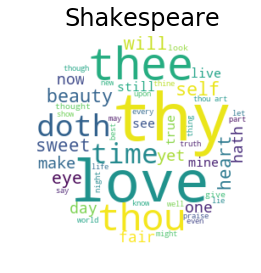

In [80]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

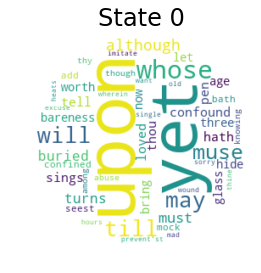

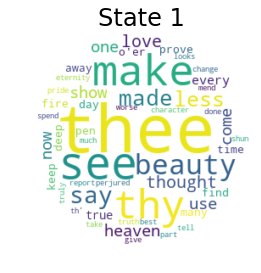

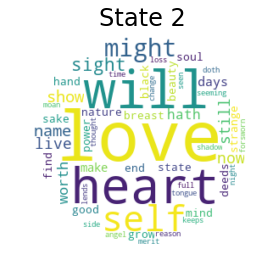

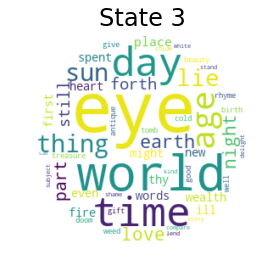

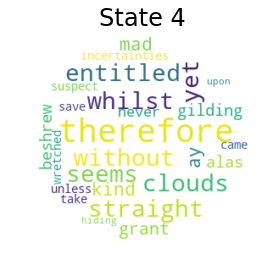

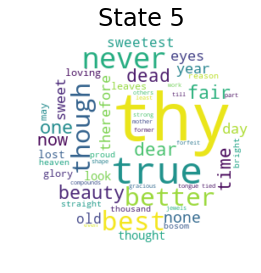

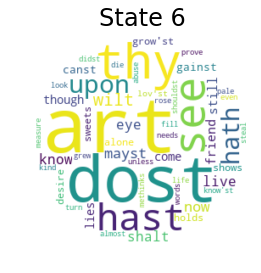

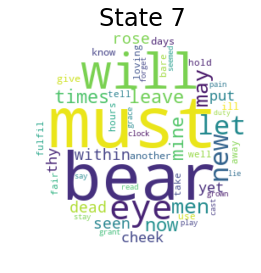

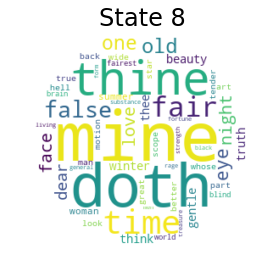

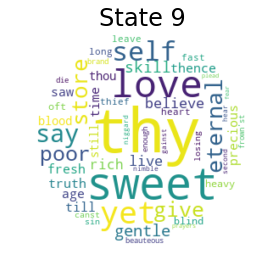

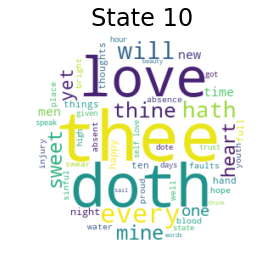

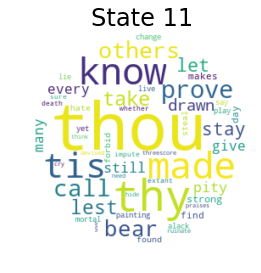

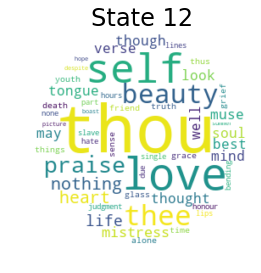

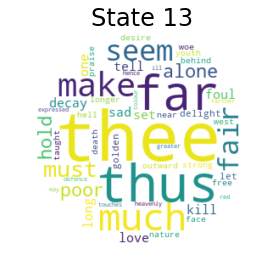

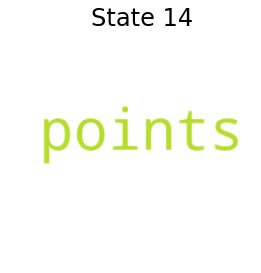

In [81]:
wordcloud = states_to_wordclouds(hmmL, obs_mapL)

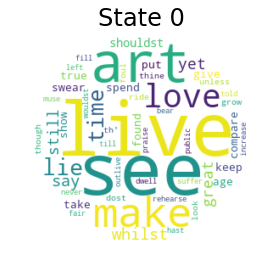

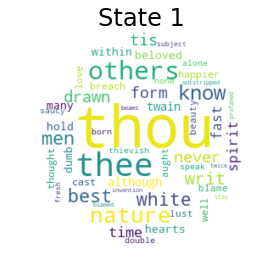

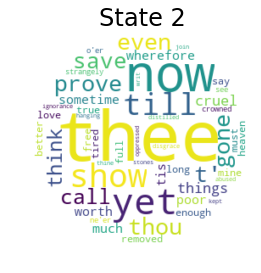

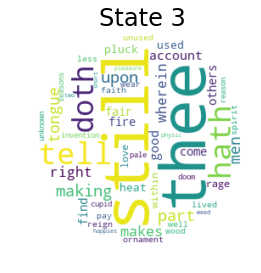

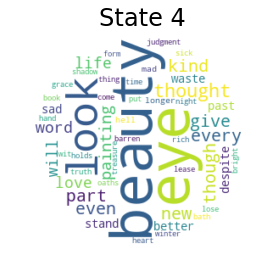

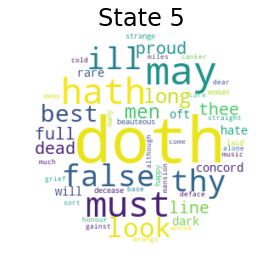

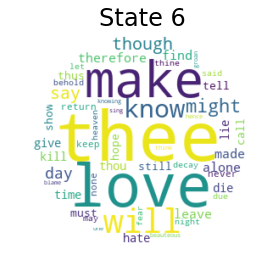

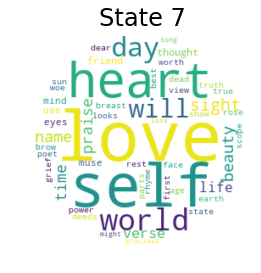

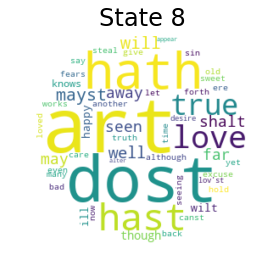

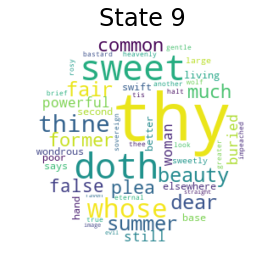

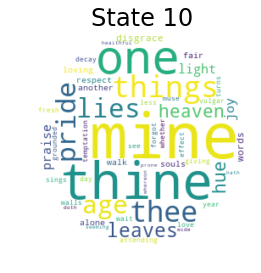

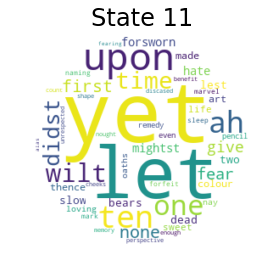

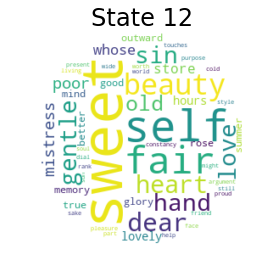

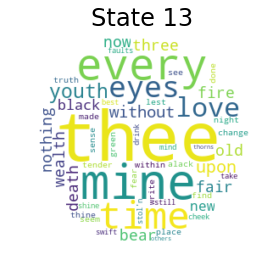

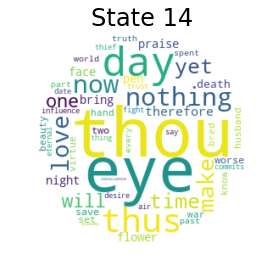

In [82]:
wordcloud = states_to_wordclouds(hmmST, obs_mapST)

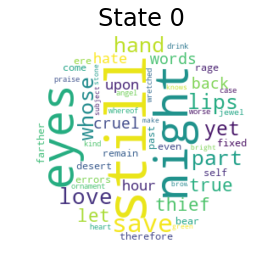

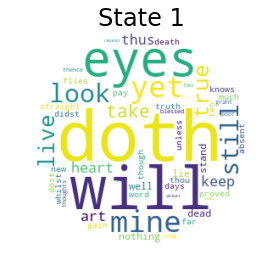

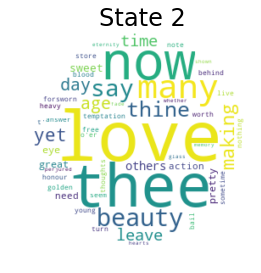

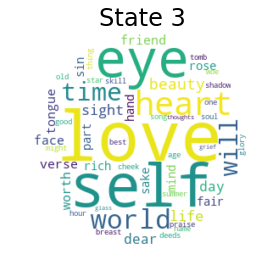

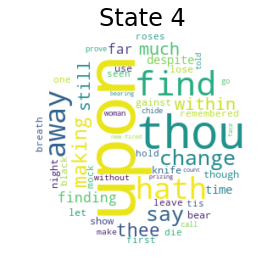

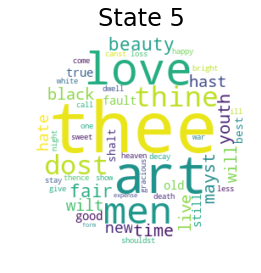

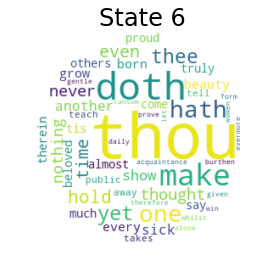

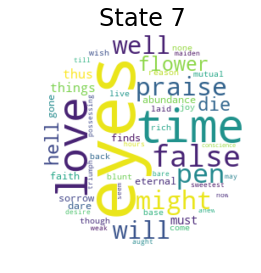

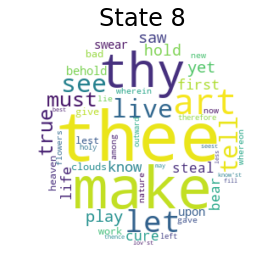

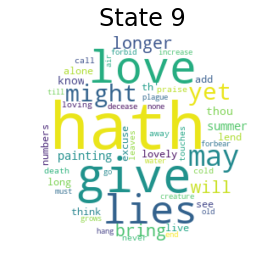

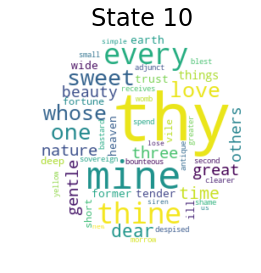

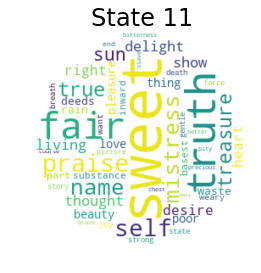

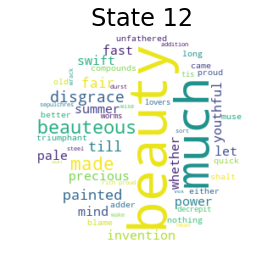

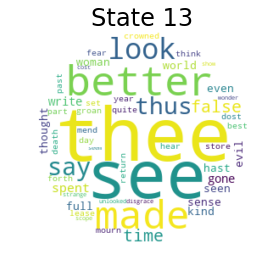

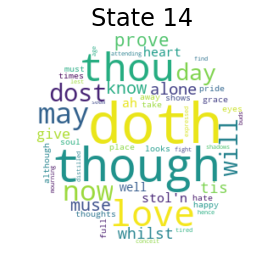

In [83]:
wordcloud = states_to_wordclouds(hmmSO, obs_mapSO)

### A (Transition) and O (Observation) Matrix Visualizations

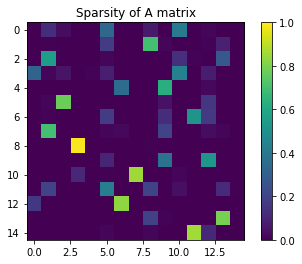

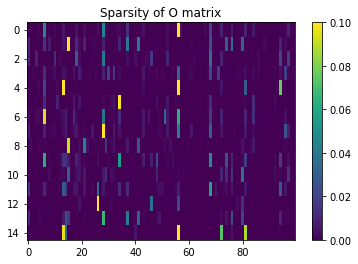

In [84]:
visualize_sparsities(hmmL, O_max_cols=100)

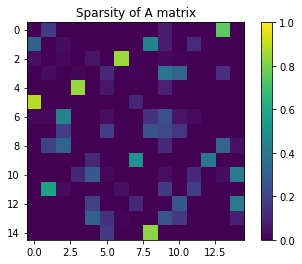

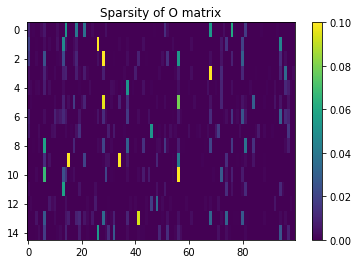

In [85]:
visualize_sparsities(hmmST, O_max_cols=100)

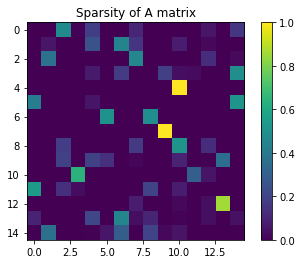

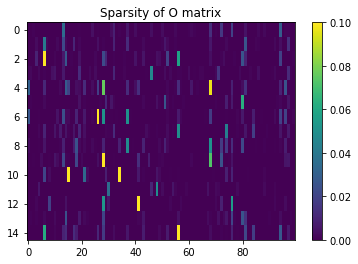

In [86]:
visualize_sparsities(hmmSO, O_max_cols=100)